In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 32.8 MB/s 
     |████████████████████████████████| 596 kB 69.0 MB/s 
     |████████████████████████████████| 101 kB 12.9 MB/s 
     |████████████████████████████████| 6.6 MB 53.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
device = torch.device("cuda")

In [ ]:
df=pd.read_csv("mixed_domain_godamit.csv",usecols=["data","label"])

In [ ]:
import pandas as pd
df1=pd.read_csv("covid_kd_val.csv",usecols=["data","label"])
df2=pd.read_csv("covid_kd_test.csv",usecols=["data","label"])

In [ ]:
df1=df1.sample(frac=1)
df1=df1.reset_index()
df1.drop("index",axis=1,inplace=True)
df2=df2.sample(frac=1)
df2=df2.reset_index()
df2.drop("index",axis=1,inplace=True)

In [ ]:
len(list(df1["label"]))

24355

In [ ]:
int(df.shape[0]*0.7)

44017

In [ ]:
df=df.sample(frac=1)

In [ ]:
df=df.reset_index()
df.drop("index",axis=1,inplace=True)
df=df.loc[:0.25*df.shape[0]]

In [ ]:
df

,level_0,data,label
0,0,u n make proposals kickstart syrian reform pro...,1
1,1,difference year makes eu warms britain may,1
2,2,breitbart joel pollack brilliantly shuts view ...,0
3,3,trump blasts john mccain lindsey graham focus ...,0
4,4,california school bans tag says game rough bre...,0
...,...,...,...
62877,62877,video incredible john bolton hill e mails tell...,0
62878,62878,twitter employee briefly shuts trump account p...,1
62879,62879,paul ryan wants make healthcare nightmare real...,0
62880,62880,federal court rules texas id law violates voti...,0


In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df.loc[:int(0.7*df.shape[0]),'data'],df.loc[:int(0.7*df.shape[0]):,'label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df.loc[:0.7*int(df.shape[0]),'label'])

In [ ]:
val_text_cov=df1.loc[:,"data"].values
val_labels_cov=df1.loc[:,"label"].values
test_text_cov=df2.loc[:,"data"].values
test_labels_cov=df2.loc[:,"label"].values

In [ ]:
model_name='bert-base-uncased'
bert = AutoModel.from_pretrained(model_name)
tokenizer = BertTokenizerFast.from_pretrained(model_name)

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
max_seq_len = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

tokens_val = tokenizer.batch_encode_plus(
    val_text_cov.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
tokens_test = tokenizer.batch_encode_plus(
    test_text_cov.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels_cov.tolist())
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels_cov.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 4
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert 
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [ ]:
device = torch.device("cuda")

In [ ]:
model = BERT_Arch(bert)
model= model.to(device)

In [ ]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels                                                    
                                    )
class_weights = dict(zip(np.unique(train_labels), class_weights))

li=[]
li.append(class_weights[0])
li.append(class_weights[1])
print(li)

[0.9870579190158892, 1.0132859773743752]


In [ ]:
class_weights

{0: 0.9865522540983607, 1: 1.0138194261647802}

In [ ]:
weights= torch.tensor(li,dtype=torch.float)
weights = weights.to(device)
cross_entropy  = nn.NLLLoss(weight=weights) 
epochs = 10

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[]
  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()        
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    #gradients are clipped to prevent the exploding gradient problem which is an unusual update in gradients during back propagation 
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)
  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [ ]:
def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  total_preds = []
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)
  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [ ]:
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss, _ = train()
    valid_loss, _ = evaluate()
    #weights of the model with the lowest validation loss are saved
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of  1,926.
  Batch   100  of  1,926.
  Batch   150  of  1,926.
  Batch   200  of  1,926.
  Batch   250  of  1,926.
  Batch   300  of  1,926.
  Batch   350  of  1,926.
  Batch   400  of  1,926.
  Batch   450  of  1,926.
  Batch   500  of  1,926.
  Batch   550  of  1,926.
  Batch   600  of  1,926.
  Batch   650  of  1,926.
  Batch   700  of  1,926.
  Batch   750  of  1,926.
  Batch   800  of  1,926.
  Batch   850  of  1,926.
  Batch   900  of  1,926.
  Batch   950  of  1,926.
  Batch 1,000  of  1,926.
  Batch 1,050  of  1,926.
  Batch 1,100  of  1,926.
  Batch 1,150  of  1,926.
  Batch 1,200  of  1,926.
  Batch 1,250  of  1,926.
  Batch 1,300  of  1,926.
  Batch 1,350  of  1,926.
  Batch 1,400  of  1,926.
  Batch 1,450  of  1,926.
  Batch 1,500  of  1,926.
  Batch 1,550  of  1,926.
  Batch 1,600  of  1,926.
  Batch 1,650  of  1,926.
  Batch 1,700  of  1,926.
  Batch 1,750  of  1,926.
  Batch 1,800  of  1,926.
  Batch 1,850  of  1,926.
  Batch 1,900  of  1,92

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
test_y = torch.tensor(test_labels_cov.tolist())
print(classification_report(test_y, preds))

In [ ]:
preds = np.argmax(preds, axis = 1)

In [ ]:
df_new=pd.DataFrame({"preds":[]})
df_new["preds"]=preds
df_new.to_csv("preds.csv")

In [ ]:
test_labels_cov=df2.loc[:,"label"].values
from sklearn.metrics import classification_report
test_y = torch.tensor(test_labels_cov.tolist())
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57      1438
           1       0.59      0.63      0.61      1485

    accuracy                           0.59      2923
   macro avg       0.59      0.59      0.59      2923
weighted avg       0.59      0.59      0.59      2923



In [ ]:
preds = np.argmax(preds, axis = 1)
from sklearn.metrics import classification_report
print(classification_report(test_y, predictions))

Text(33.0, 0.5, 'Truth')

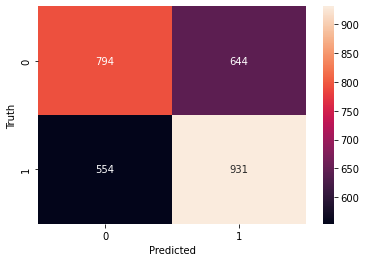

In [ ]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn
cm = confusion_matrix(test_y, preds)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
df1.shape

(24355, 2)

Fine-Tuning for 1 month

In [ ]:
for i in range(1,25):
  train_text_cov=df1.loc[:int(i*0.6*100),'data'].values
  train_labels_cov=df1.loc[:int(i*0.6*100),'label'].values
  val_text_cov=df1.loc[int(i*0.6*100):int(i*0.8*100),'data'].values
  val_labels_cov=df1.loc[int(i*0.6*100):int(i*0.8*100),"label"].values
  test_text_cov=df1.loc[int(i*0.8*100):,'data'].values
  test_labels_cov=df1.loc[int(i*0.8*100):,'label'].values
  max_seq_len = 15
  tokens_train = tokenizer.batch_encode_plus(
      train_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  tokens_val = tokenizer.batch_encode_plus(
    val_text_cov.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
  tokens_test = tokenizer.batch_encode_plus(
      test_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  train_seq = torch.tensor(tokens_train['input_ids'])
  train_mask = torch.tensor(tokens_train['attention_mask'])
  train_y = torch.tensor(train_labels_cov.tolist())
  val_seq = torch.tensor(tokens_val['input_ids'])
  val_mask = torch.tensor(tokens_val['attention_mask'])
  val_y = torch.tensor(val_labels_cov.tolist())
  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  test_y = torch.tensor(test_labels_cov.tolist())
  batch_size = 2
  train_data = TensorDataset(train_seq, train_mask, train_y)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  val_data = TensorDataset(val_seq, val_mask, val_y)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
  best_valid_loss = float('inf')
  train_losses=[]
  valid_losses=[]
  epochs=4
  for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      train_loss, _ = train()
      valid_loss, _ = evaluate()
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
  path = 'saved_weights.pt'
  model.load_state_dict(torch.load(path))
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  test_y = torch.tensor(test_labels_cov.tolist())
  print(classification_report(test_y, preds))


Fine-Tuning for 2 months

In [ ]:
for i in range(2,26,2):
  train_text_cov=df1.loc[:int(i*0.6*100),'data'].values
  train_labels_cov=df1.loc[:int(i*0.6*100),'label'].values
  val_text_cov=df1.loc[int(i*0.6*100):int(i*0.8*100),'data'].values
  val_labels_cov=df1.loc[int(i*0.6*100):int(i*0.8*100),"label"].values
  test_text_cov=df1.loc[int(i*0.8*100):,'data'].values
  test_labels_cov=df1.loc[int(i*0.8*100):,'label'].values
  max_seq_len = 15
  tokens_train = tokenizer.batch_encode_plus(
      train_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  tokens_val = tokenizer.batch_encode_plus(
    val_text_cov.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
  tokens_test = tokenizer.batch_encode_plus(
      test_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  train_seq = torch.tensor(tokens_train['input_ids'])
  train_mask = torch.tensor(tokens_train['attention_mask'])
  train_y = torch.tensor(train_labels_cov.tolist())
  val_seq = torch.tensor(tokens_val['input_ids'])
  val_mask = torch.tensor(tokens_val['attention_mask'])
  val_y = torch.tensor(val_labels_cov.tolist())
  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  test_y = torch.tensor(test_labels_cov.tolist())
  batch_size = 2
  train_data = TensorDataset(train_seq, train_mask, train_y)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  val_data = TensorDataset(val_seq, val_mask, val_y)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
  best_valid_loss = float('inf')
  train_losses=[]
  valid_losses=[]
  epochs=4
  for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      train_loss, _ = train()
      valid_loss, _ = evaluate()
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
  path = 'saved_weights.pt'
  model.load_state_dict(torch.load(path))
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  test_y = torch.tensor(test_labels_cov.tolist())
  print(classification_report(test_y, preds))


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of     61.

Evaluating...

Training Loss: 0.573
Validation Loss: 0.493

 Epoch 2 / 4
  Batch    50  of     61.

Evaluating...

Training Loss: 0.538
Validation Loss: 0.500

 Epoch 3 / 4
  Batch    50  of     61.

Evaluating...

Training Loss: 0.562
Validation Loss: 0.502

 Epoch 4 / 4
  Batch    50  of     61.

Evaluating...

Training Loss: 0.508
Validation Loss: 0.755


RuntimeError: ignored

Fine-Tuning for 3 months

In [ ]:
for i in range(3,27,3):
  train_text_cov=df1.loc[:int(0.0416*i*0.6*df1.shape[0]),'data'].values
  train_labels_cov=df1.loc[:int(0.0416*i*0.6*df1.shape[0]),'label'].values
  val_text_cov=df1.loc[int(0.0416*i*0.6*df1.shape[0]):int(0.0416*i*0.8*df1.shape[0]),'data'].values
  val_labels_cov=df1.loc[int(0.0416*i*0.6*df1.shape[0]):int(0.0416*i*0.8*df1.shape[0]),"label"].values
  test_text_cov=df1.loc[int(0.0416*i*0.8*df1.shape[0]):,'data'].values
  test_labels_cov=df1.loc[int(0.0416*i*0.8*df1.shape[0]):,'label'].values
  max_seq_len = 15
  tokens_train = tokenizer.batch_encode_plus(
      train_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  tokens_val = tokenizer.batch_encode_plus(
    val_text_cov.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
  tokens_test = tokenizer.batch_encode_plus(
      test_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  train_seq = torch.tensor(tokens_train['input_ids'])
  train_mask = torch.tensor(tokens_train['attention_mask'])
  train_y = torch.tensor(train_labels_cov.tolist())
  val_seq = torch.tensor(tokens_val['input_ids'])
  val_mask = torch.tensor(tokens_val['attention_mask'])
  val_y = torch.tensor(val_labels_cov.tolist())
  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  test_y = torch.tensor(test_labels_cov.tolist())
  batch_size = 12
  train_data = TensorDataset(train_seq, train_mask, train_y)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  val_data = TensorDataset(val_seq, val_mask, val_y)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
  best_valid_loss = float('inf')
  train_losses=[]
  valid_losses=[]
  epochs=4
  for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      train_loss, _ = train()
      valid_loss, _ = evaluate()
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
  path = 'saved_weights.pt'
  model.load_state_dict(torch.load(path))
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  test_y = torch.tensor(test_labels_cov.tolist())
  print(classification_report(test_y, preds))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.662
Validation Loss: 0.636

 Epoch 2 / 4
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.620
Validation Loss: 0.589

 Epoch 3 / 4
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.591
Validation Loss: 0.539

 Epoch 4 / 4
  Batch    50  of    110.
  Batch   100  of    110.

Evaluating...

Training Loss: 0.587
Validation Loss: 0.538
              precision    recall  f1-score   support

           0       0.80      0.69      0.74      7864
           1       0.73      0.82      0.77      7921

    accuracy                           0.76     15785
   macro avg       0.76      0.76      0.76     15785
weighted avg       0.76      0.76      0.76     15785



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    219.
  Batch   100  of    219.
  Batch   150  of    219.
  Batch   200  of    219.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.552
Validation Loss: 0.485

 Epoch 2 / 4
  Batch    50  of    219.
  Batch   100  of    219.
  Batch   150  of    219.
  Batch   200  of    219.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.516
Validation Loss: 0.473

 Epoch 3 / 4
  Batch    50  of    219.
  Batch   100  of    219.
  Batch   150  of    219.
  Batch   200  of    219.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.487
Validation Loss: 0.450

 Epoch 4 / 4
  Batch    50  of    219.
  Batch   100  of    219.
  Batch   150  of    219.
  Batch   200  of    219.

Evaluating...
  Batch    50  of     73.

Training Loss: 0.472
Validation Loss: 0.457
              precision    recall  f1-score   support

           0       0.77      0.87      0.81      6996
           1       0.85      0.74      0.79      7038

    accuracy        

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    329.
  Batch   100  of    329.
  Batch   150  of    329.
  Batch   200  of    329.
  Batch   250  of    329.
  Batch   300  of    329.

Evaluating...
  Batch    50  of    110.
  Batch   100  of    110.

Training Loss: 0.466
Validation Loss: 0.415

 Epoch 2 / 4
  Batch    50  of    329.
  Batch   100  of    329.
  Batch   150  of    329.
  Batch   200  of    329.
  Batch   250  of    329.
  Batch   300  of    329.

Evaluating...
  Batch    50  of    110.
  Batch   100  of    110.

Training Loss: 0.451
Validation Loss: 0.397

 Epoch 3 / 4
  Batch    50  of    329.
  Batch   100  of    329.
  Batch   150  of    329.
  Batch   200  of    329.
  Batch   250  of    329.
  Batch   300  of    329.

Evaluating...
  Batch    50  of    110.
  Batch   100  of    110.

Training Loss: 0.443
Validation Loss: 0.376

 Epoch 4 / 4
  Batch    50  of    329.
  Batch   100  of    329.
  Batch   150  of    329.
  Batch   200  of    329.
  Batch   250  of    329.
  Batch   

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    438.
  Batch   200  of    438.
  Batch   250  of    438.
  Batch   300  of    438.
  Batch   350  of    438.
  Batch   400  of    438.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 0.430
Validation Loss: 0.358

 Epoch 2 / 4
  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    438.
  Batch   200  of    438.
  Batch   250  of    438.
  Batch   300  of    438.
  Batch   350  of    438.
  Batch   400  of    438.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 0.420
Validation Loss: 0.331

 Epoch 3 / 4
  Batch    50  of    438.
  Batch   100  of    438.
  Batch   150  of    438.
  Batch   200  of    438.
  Batch   250  of    438.
  Batch   300  of    438.
  Batch   350  of    438.
  Batch   400  of    438.

Evaluating...
  Batch    50  of    146.
  Batch   100  of    146.

Training Loss: 0.415
Validation Loss: 0.32

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    548.
  Batch   100  of    548.
  Batch   150  of    548.
  Batch   200  of    548.
  Batch   250  of    548.
  Batch   300  of    548.
  Batch   350  of    548.
  Batch   400  of    548.
  Batch   450  of    548.
  Batch   500  of    548.

Evaluating...
  Batch    50  of    183.
  Batch   100  of    183.
  Batch   150  of    183.

Training Loss: 0.410
Validation Loss: 0.333

 Epoch 2 / 4
  Batch    50  of    548.
  Batch   100  of    548.
  Batch   150  of    548.
  Batch   200  of    548.
  Batch   250  of    548.
  Batch   300  of    548.
  Batch   350  of    548.
  Batch   400  of    548.
  Batch   450  of    548.
  Batch   500  of    548.

Evaluating...
  Batch    50  of    183.
  Batch   100  of    183.
  Batch   150  of    183.

Training Loss: 0.405
Validation Loss: 0.343

 Epoch 3 / 4
  Batch    50  of    548.
  Batch   100  of    548.
  Batch   150  of    548.
  Batch   200  of    548.
  Batch   250  of    548.
  Batch   300  of    548.
  Batc

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    657.
  Batch   100  of    657.
  Batch   150  of    657.
  Batch   200  of    657.
  Batch   250  of    657.
  Batch   300  of    657.
  Batch   350  of    657.
  Batch   400  of    657.
  Batch   450  of    657.
  Batch   500  of    657.
  Batch   550  of    657.
  Batch   600  of    657.
  Batch   650  of    657.

Evaluating...
  Batch    50  of    219.
  Batch   100  of    219.
  Batch   150  of    219.
  Batch   200  of    219.

Training Loss: 0.387
Validation Loss: 0.343

 Epoch 2 / 4
  Batch    50  of    657.
  Batch   100  of    657.
  Batch   150  of    657.
  Batch   200  of    657.
  Batch   250  of    657.
  Batch   300  of    657.
  Batch   350  of    657.
  Batch   400  of    657.
  Batch   450  of    657.
  Batch   500  of    657.
  Batch   550  of    657.
  Batch   600  of    657.
  Batch   650  of    657.

Evaluating...
  Batch    50  of    219.
  Batch   100  of    219.
  Batch   150  of    219.
  Batch   200  of    219.

Training Los

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    766.
  Batch   100  of    766.
  Batch   150  of    766.
  Batch   200  of    766.
  Batch   250  of    766.
  Batch   300  of    766.
  Batch   350  of    766.
  Batch   400  of    766.
  Batch   450  of    766.
  Batch   500  of    766.
  Batch   550  of    766.
  Batch   600  of    766.
  Batch   650  of    766.
  Batch   700  of    766.
  Batch   750  of    766.

Evaluating...
  Batch    50  of    256.
  Batch   100  of    256.
  Batch   150  of    256.
  Batch   200  of    256.
  Batch   250  of    256.

Training Loss: 0.383
Validation Loss: 0.319

 Epoch 2 / 4
  Batch    50  of    766.
  Batch   100  of    766.
  Batch   150  of    766.
  Batch   200  of    766.
  Batch   250  of    766.
  Batch   300  of    766.
  Batch   350  of    766.
  Batch   400  of    766.
  Batch   450  of    766.
  Batch   500  of    766.
  Batch   550  of    766.
  Batch   600  of    766.
  Batch   650  of    766.
  Batch   700  of    766.
  Batch   750  of    766.

E

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,



 Epoch 1 / 4
  Batch    50  of    876.
  Batch   100  of    876.
  Batch   150  of    876.
  Batch   200  of    876.
  Batch   250  of    876.
  Batch   300  of    876.
  Batch   350  of    876.
  Batch   400  of    876.
  Batch   450  of    876.
  Batch   500  of    876.
  Batch   550  of    876.
  Batch   600  of    876.
  Batch   650  of    876.
  Batch   700  of    876.
  Batch   750  of    876.
  Batch   800  of    876.
  Batch   850  of    876.

Evaluating...
  Batch    50  of    292.
  Batch   100  of    292.
  Batch   150  of    292.
  Batch   200  of    292.
  Batch   250  of    292.

Training Loss: 0.373
Validation Loss: 0.313

 Epoch 2 / 4
  Batch    50  of    876.
  Batch   100  of    876.
  Batch   150  of    876.
  Batch   200  of    876.
  Batch   250  of    876.
  Batch   300  of    876.
  Batch   350  of    876.
  Batch   400  of    876.
  Batch   450  of    876.
  Batch   500  of    876.
  Batch   550  of    876.
  Batch   600  of    876.
  Batch   650  of    876.
  

In [ ]:
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)

Fine-Tuning for 4 month quantum

In [ ]:
for i in range(4,28,4):
  train_text_cov=df1.loc[:int(0.0416*i*0.6*df1.shape[0]),'data'].values
  train_labels_cov=df1.loc[:int(0.0416*i*0.6*df1.shape[0]),'label'].values
  val_text_cov=df1.loc[int(0.0416*i*0.6*df1.shape[0]):int(0.0416*i*0.8*df1.shape[0]),'data'].values
  val_labels_cov=df1.loc[int(0.0416*i*0.6*df1.shape[0]):int(0.0416*i*0.8*df1.shape[0]),"label"].values
  test_text_cov=df1.loc[int(0.0416*i*0.8*df1.shape[0]):,'data'].values
  test_labels_cov=df1.loc[int(0.0416*i*0.8*df1.shape[0]):,'label'].values
  max_seq_len = 15
  tokens_train = tokenizer.batch_encode_plus(
      train_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  tokens_val = tokenizer.batch_encode_plus(
    val_text_cov.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)
  tokens_test = tokenizer.batch_encode_plus(
      test_text_cov.tolist(),
      max_length = max_seq_len,
      pad_to_max_length=True,
      truncation=True,
      return_token_type_ids=False
  )
  train_seq = torch.tensor(tokens_train['input_ids'])
  train_mask = torch.tensor(tokens_train['attention_mask'])
  train_y = torch.tensor(train_labels_cov.tolist())
  val_seq = torch.tensor(tokens_val['input_ids'])
  val_mask = torch.tensor(tokens_val['attention_mask'])
  val_y = torch.tensor(val_labels_cov.tolist())
  test_seq = torch.tensor(tokens_test['input_ids'])
  test_mask = torch.tensor(tokens_test['attention_mask'])
  test_y = torch.tensor(test_labels_cov.tolist())
  batch_size = 12
  train_data = TensorDataset(train_seq, train_mask, train_y)
  train_sampler = RandomSampler(train_data)
  train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
  val_data = TensorDataset(val_seq, val_mask, val_y)
  val_sampler = SequentialSampler(val_data)
  val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
  best_valid_loss = float('inf')
  train_losses=[]
  valid_losses=[]
  epochs=4
  for epoch in range(epochs):
      print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
      train_loss, _ = train()
      valid_loss, _ = evaluate()
      if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
      train_losses.append(train_loss)
      valid_losses.append(valid_loss)
      print(f'\nTraining Loss: {train_loss:.3f}')
      print(f'Validation Loss: {valid_loss:.3f}')
  path = 'saved_weights.pt'
  model.load_state_dict(torch.load(path))
  with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()
  preds = np.argmax(preds, axis = 1)
  test_y = torch.tensor(test_labels_cov.tolist())
  print(classification_report(test_y, preds))):
  

In [ ]:
df_new=pd.DataFrame({"preds":[]})
df_new["preds"]=preds
df_new.to_csv("preds2.csv")

In [ ]:
print(classification_report(test_y, preds))
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn
cm = confusion_matrix(test_y, preds)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')